# Telecom Churn Case Study
## Problem Statement
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
* For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.
* Analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

In [192]:
# Import necessary packages
import numpy as np
import pandas as pd

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For missing value imputation
from sklearn.impute import KNNImputer

# For train-test split
from sklearn.model_selection import train_test_split

# For handling class imbalance
from imblearn.over_sampling import SMOTE

# For rescaling features
from sklearn.preprocessing import MinMaxScaler

# For PCA (principal component analysis)
from sklearn.decomposition import PCA

# For model building
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For model evaluation
from sklearn import metrics

In [193]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# For displaying all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Read the data

In [194]:
# Read data from csv file to a dataframe
df = pd.read_csv("telecom_churn_data.csv")

# Check head of the dataframe
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [195]:
# Check shape of the dataframe
df.shape

(99999, 226)

## The steps are:
1. Filter high value customers (HVC)
2. Data cleaning
3. Derive churn
4. Data preparation
5. Modelling

## 1. Filter high value customers (HVC)

In [196]:
# Find average recharge amount for the good phase (months 6 and 7)
df['avg_rech_6_7'] = (df['total_rech_amt_6']+df['total_rech_amt_7'])/2

# Select customers above and equal to the 70th percentile
val = df['avg_rech_6_7'].quantile(0.7)
df = df[df['avg_rech_6_7'] >= val]

In [197]:
# Check shape of the dataframe
df.shape

(30011, 227)

## 2. Data cleaning

#### Redundant values

In [198]:
# Drop columns with only one value
cols1 = []
for col in df.columns:
    if df[col].nunique() == 1:
        cols1.append(col)
df = df.drop(cols1, axis=1)

# Check shape of the dataframe
df.shape

(30011, 211)

In [199]:
# Check summary statistics for average revenue columns
df[["arpu_6","arpu_7","arpu_8","arpu_9"]].describe()

,arpu_6,arpu_7,arpu_8,arpu_9
count,30011.000000,30011.000000,30011.000000,30011.000000
mean,587.284404,589.135427,534.857433,488.656197
std,442.722413,462.897814,492.259586,496.486834
min,-2258.709000,-2014.045000,-945.808000,-1899.505000
25%,364.161000,365.004500,289.609500,239.184000
50%,495.682000,493.561000,452.091000,413.152000
75%,703.922000,700.788000,671.150000,635.553000
max,27731.088000,35145.834000,33543.624000,38805.617000


In [200]:
# Drop rows containing negative values for average revenue
df = df[(df.arpu_6>=0) & (df.arpu_7>=0) & (df.arpu_8>=0) & (df.arpu_9>=0)]
df = df.reset_index(drop=True)

# Check shape of the dataframe
df.shape

(29740, 211)

In [201]:
# Drop the date columns
cols2 = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9']
df = df.drop(cols2, axis=1)

# Check shape of the dataframe
df.shape

(29740, 207)

### Missing data

In [202]:
# Check percentage of missing data in columns
pd.set_option('display.max_rows', None)
((df.isnull().sum()/len(df))*100).round(2).sort_values(ascending=False)

arpu_3g_6                   61.93
date_of_last_rech_data_6    61.93
night_pck_user_6            61.93
arpu_2g_6                   61.93
count_rech_3g_6             61.93
fb_user_6                   61.93
total_rech_data_6           61.93
av_rech_amt_data_6          61.93
count_rech_2g_6             61.93
max_rech_data_6             61.93
count_rech_2g_9             61.51
night_pck_user_9            61.51
count_rech_3g_9             61.51
arpu_3g_9                   61.51
max_rech_data_9             61.51
arpu_2g_9                   61.51
total_rech_data_9           61.51
fb_user_9                   61.51
date_of_last_rech_data_9    61.51
av_rech_amt_data_9          61.51
arpu_2g_7                   60.99
av_rech_amt_data_7          60.99
count_rech_2g_7             60.99
arpu_3g_7                   60.99
total_rech_data_7           60.99
fb_user_7                   60.99
count_rech_3g_7             60.99
night_pck_user_7            60.99
date_of_last_rech_data_7    60.99
max_rech_data_

In [203]:
# Impute missing values with 0 for night pack (for customers not availing this facility)
cols3 = ["night_pck_user_6","night_pck_user_7","night_pck_user_8"]
df[cols3] = df[cols3].fillna(0)

In [204]:
# Impute missing values with 0 for fb user (for customers not availing this facility)
cols4 = ["fb_user_6","fb_user_7","fb_user_8"]
df[cols4] = df[cols4].fillna(0)

In [205]:
# Impute missing values with 0 for total recharge data (recharge not done)
# Similarly, impute missing values for amount and other recharge data with 0

cols5 = ['total_rech_data_6','count_rech_2g_6','arpu_3g_6','arpu_2g_6','av_rech_amt_data_6',
         'max_rech_data_6','count_rech_3g_6','total_rech_data_7','max_rech_data_7' ,
         'arpu_3g_7','count_rech_2g_7','av_rech_amt_data_7','count_rech_3g_7','arpu_2g_7',
         'arpu_3g_8','max_rech_data_8','av_rech_amt_data_8','arpu_2g_8','count_rech_3g_8',
         'total_rech_data_8','count_rech_2g_8']
df[cols5] = df[cols5].fillna(0)

In [206]:
# Drop columns with high percentage (> 50%) of missing data
s6 = (df.isnull().sum()/len(df))*100
cols6 = s6[s6 > 50].index
df = df.drop(cols6, axis=1)

# Check shape of the dataframe
df.shape

(29740, 194)

In [207]:
# Check percentage of missing data again
((df.isnull().sum()/len(df))*100).round(2).sort_values(ascending=False)

std_ic_t2m_mou_9      5.26
roam_ic_mou_9         5.26
std_ic_mou_9          5.26
loc_og_mou_9          5.26
loc_og_t2f_mou_9      5.26
spl_og_mou_9          5.26
std_ic_t2f_mou_9      5.26
loc_og_t2m_mou_9      5.26
std_og_t2t_mou_9      5.26
spl_ic_mou_9          5.26
loc_og_t2t_mou_9      5.26
loc_ic_t2t_mou_9      5.26
std_og_t2m_mou_9      5.26
roam_og_mou_9         5.26
std_ic_t2t_mou_9      5.26
isd_ic_mou_9          5.26
ic_others_9           5.26
std_og_mou_9          5.26
loc_ic_t2m_mou_9      5.26
isd_og_mou_9          5.26
loc_ic_t2f_mou_9      5.26
og_others_9           5.26
std_og_t2f_mou_9      5.26
onnet_mou_9           5.26
loc_og_t2c_mou_9      5.26
loc_ic_mou_9          5.26
offnet_mou_9          5.26
std_og_t2m_mou_8      2.90
std_og_mou_8          2.90
std_og_t2t_mou_8      2.90
isd_ic_mou_8          2.90
spl_ic_mou_8          2.90
isd_og_mou_8          2.90
loc_ic_t2t_mou_8      2.90
ic_others_8           2.90
og_others_8           2.90
loc_og_mou_8          2.90
s

In [208]:
# Impute remaining missing values with KNN imputer
imputer = KNNImputer(n_neighbors=5)
df_clean = pd.DataFrame(imputer.fit_transform(df))
df_clean.columns = df.columns

In [209]:
# Check number of columns with missing data
df_clean.isnull().any().sum()

0

Hence, all missing data has been handled.

## 3. Derive churn

Usage-based churn is defined as no calls (incoming/outgoing) or internet (2G/3G) usage over a period of time.

In [210]:
# Create churn column (churn=1, else 0) from the churn phase (month 9)
df_clean["usage"] = df_clean['total_ic_mou_9']+df_clean['total_og_mou_9']+df_clean['vol_2g_mb_9']+df_clean['vol_3g_mb_9']+df_clean['sep_vbc_3g']
df_clean["churn"] = [0 if x>0 else 1 for x in df_clean["usage"]]
df_clean = df_clean.drop("usage", axis=1)

# Check value counts of the churn column
df_clean['churn'].value_counts()

0    27320
1     2420
Name: churn, dtype: int64

In [211]:
# Check churn percentage
round(100*df_clean['churn'].sum()/len(df_clean), 2)

8.14

In [212]:
# Drop columns corresponding to the churn phase (month 9)
cols7 = [col for col in df_clean.columns if '_9' in col]
df_clean = df_clean.drop(cols7, axis=1)
df_clean = df_clean.drop('sep_vbc_3g', axis=1)

# Check shape of the dataframe
df_clean.shape

(29740, 154)

## 4. Data Preparation
#### Steps include:
1. Derived variables
2. EDA
3. Outlier treatment

### Derived variables

In [213]:
# Create column for Facebook user or not
df_clean["fb_user"] = df_clean[['fb_user_6','fb_user_7','fb_user_8']].max(axis=1)

In [214]:
# Create column for night pack user or not
df_clean["night_pck_user"] = df_clean[['night_pck_user_6','night_pck_user_7','night_pck_user_8']].max(axis=1)

In [215]:
# Convert aon to number of months
df_clean["old_cust_mon"] = round(df_clean["aon"]/30, 0)
df_clean = df_clean.drop("aon", axis=1)

### Derived variables and EDA

In [216]:
# Function to perform log transform
def log_transform(df,item):
    df[item] = (df[item]+1).transform(np.log)
    return df

In [217]:
# Function to select specific columns
def columns_cont(df,text):
    col_text = [col for col in df.columns if text in col]
    col_text.extend(["mobile_number","churn"])
    df_text = df_clean[col_text]
    plt.figure(figsize=(10,10))
    sns.heatmap(round(df_text.corr(),2),annot=True) # Plot correlation heatmap
    plt.show()
    df_text = df_text.melt(id_vars=["mobile_number","churn"], var_name=text)
    return df_text

In [218]:
# Function to find average percentage change
def drop_in_perc(a_6,a_7,a_8):
    avg = round((a_6+a_7)/2, 0)
    drop = round(100*(avg-a_8)/avg, 0)
    drop = drop.fillna(-100) # Imputing the value as -100 if avg is 0 (for nan)
    drop = np.clip(drop,-100,100) # Capping the lower and higher value to -100 and 100
    return drop

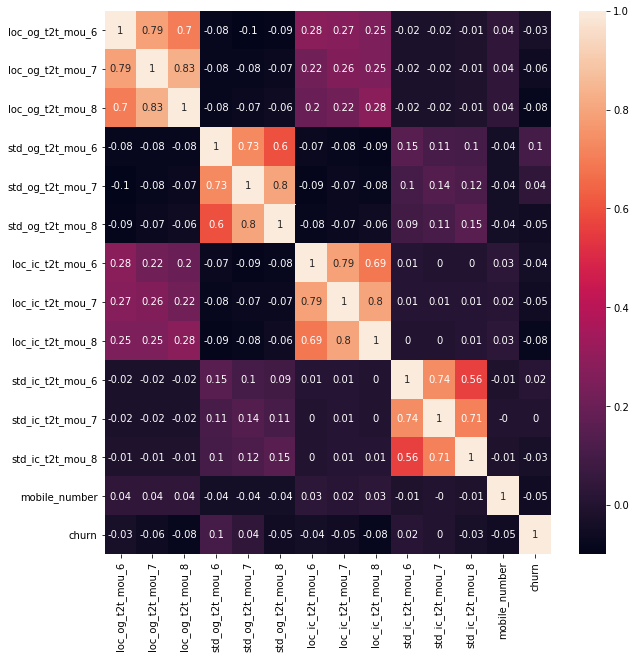

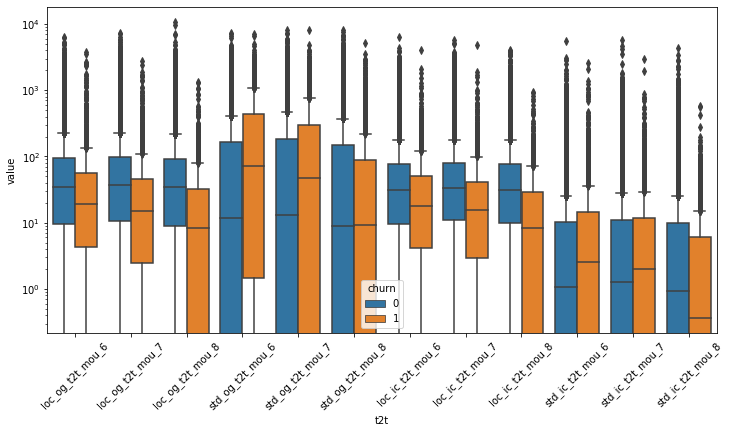

In [219]:
# Analysis of columns related to t2t (operator T to T)
df_t2t = columns_cont(df_clean,"t2t")
t2t = df_t2t.t2t.unique()

plt.figure(figsize=(12,6))
plt.yscale("log")
sns.boxplot(x="t2t", y="value", hue="churn", data=df_t2t)
plt.xticks(rotation=45);

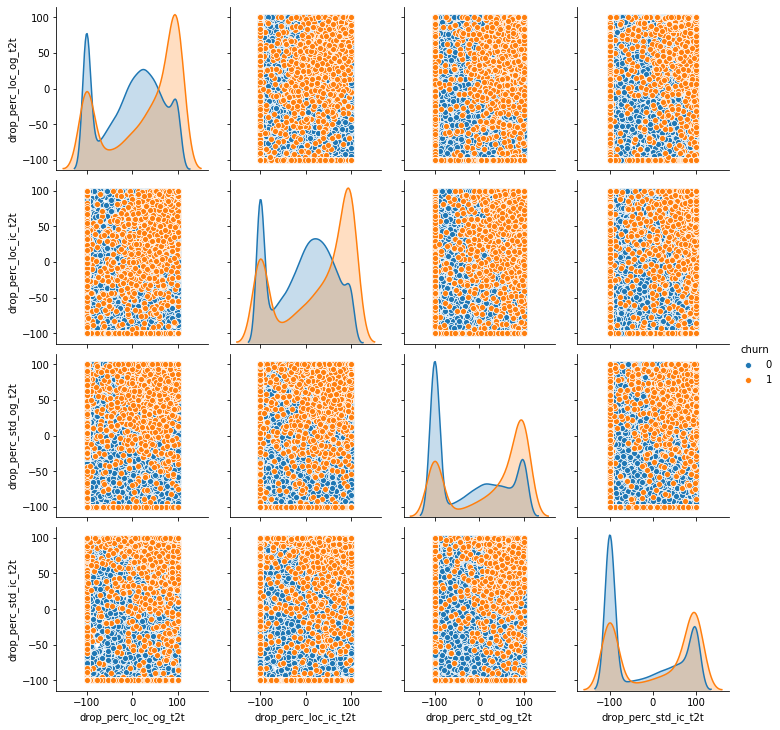

In [220]:
# Create percentage drop columns for t2t
df_clean["drop_perc_loc_og_t2t"] = drop_in_perc(df_clean.loc_og_t2t_mou_6,df_clean.loc_og_t2t_mou_7,df_clean.loc_og_t2t_mou_8)
df_clean["drop_perc_loc_ic_t2t"] = drop_in_perc(df_clean.loc_ic_t2t_mou_6,df_clean.loc_ic_t2t_mou_7,df_clean.loc_ic_t2t_mou_8)
df_clean["drop_perc_std_og_t2t"] = drop_in_perc(df_clean.std_og_t2t_mou_6,df_clean.std_og_t2t_mou_7,df_clean.std_og_t2t_mou_8)
df_clean["drop_perc_std_ic_t2t"] = drop_in_perc(df_clean.std_ic_t2t_mou_6,df_clean.std_ic_t2t_mou_7,df_clean.std_ic_t2t_mou_8)

# Since the data for individual months is highly corelated, drop the t2t columns for months 6 and 7
drop_6_7 = [x for x in t2t if x[-1] in ["6","7"]]
df_clean = df_clean.drop(drop_6_7, axis=1)

# Analysis of percentage drop columns for t2t
perc_cols1 = ["drop_perc_loc_og_t2t","drop_perc_loc_ic_t2t","drop_perc_std_og_t2t","drop_perc_std_ic_t2t"]
sns.pairplot(df_clean, x_vars=perc_cols1, y_vars=perc_cols1, hue="churn");

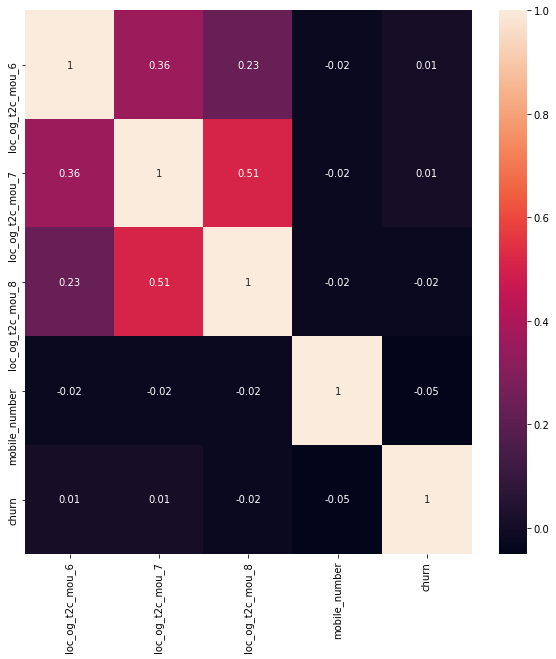

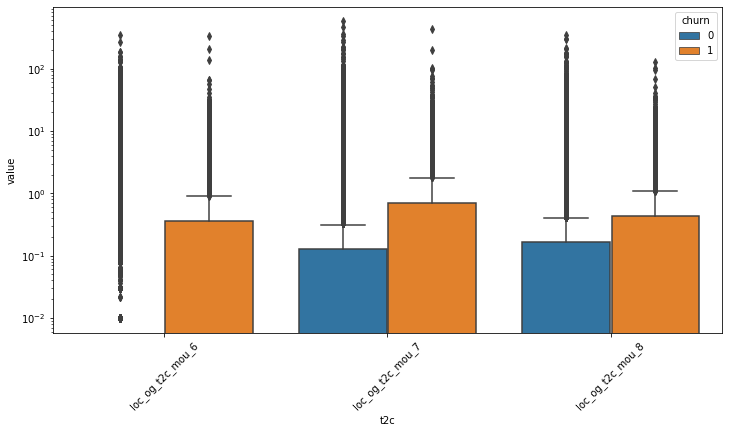

In [221]:
# Analysis of columns related to t2c (operator T to call center)
df_t2c = columns_cont(df_clean,"t2c")
t2c = df_t2c.t2c.unique()

plt.figure(figsize=(12,6))
plt.yscale('log')
sns.boxplot(x="t2c", y="value", hue="churn", data=df_t2c)
plt.xticks(rotation=45);

In [222]:
# There is a drop for most of the churned customers in local og t2c calls
df_clean["drop_loc_og_t2c"] = drop_in_perc(df_clean.loc_og_t2c_mou_6,df_clean.loc_og_t2c_mou_7,df_clean.loc_og_t2c_mou_8)
df_clean["drop_loc_og_7_8"] = np.where((df_clean['loc_og_t2c_mou_7']>df_clean['loc_og_t2c_mou_8']), 1, 0)

# Drop individial columns
df_clean = df_clean.drop(["loc_og_t2c_mou_6","loc_og_t2c_mou_7","loc_og_t2c_mou_8"], axis=1)

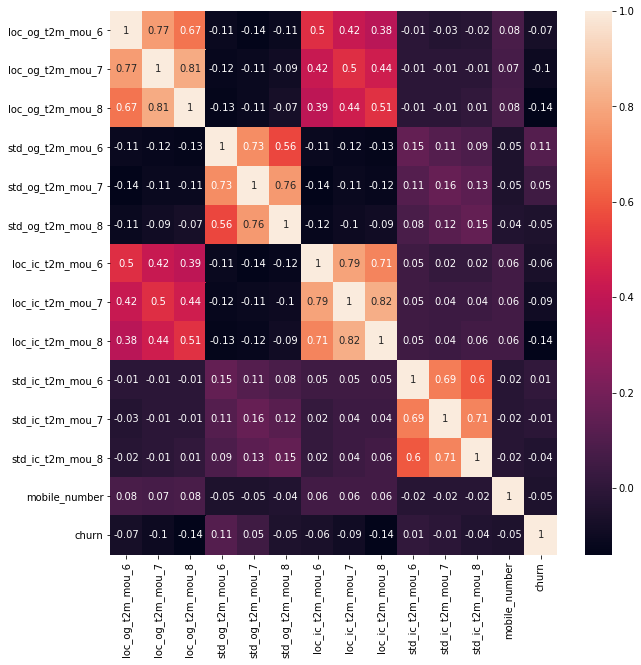

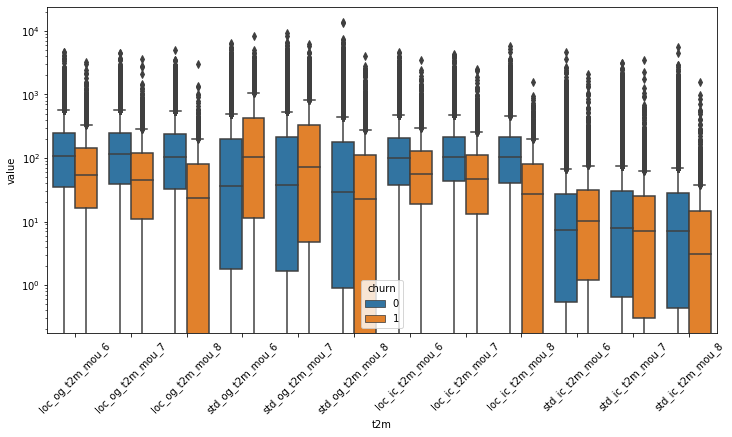

In [223]:
# Analysis of columns related to t2m (operator T to other operator mobile)
df_t2m = columns_cont(df_clean,"t2m")
t2m = df_t2m.t2m.unique()

plt.figure(figsize=(12,6))
plt.yscale("log")
sns.boxplot(x="t2m", y="value", hue="churn", data=df_t2m)
plt.xticks(rotation=45);

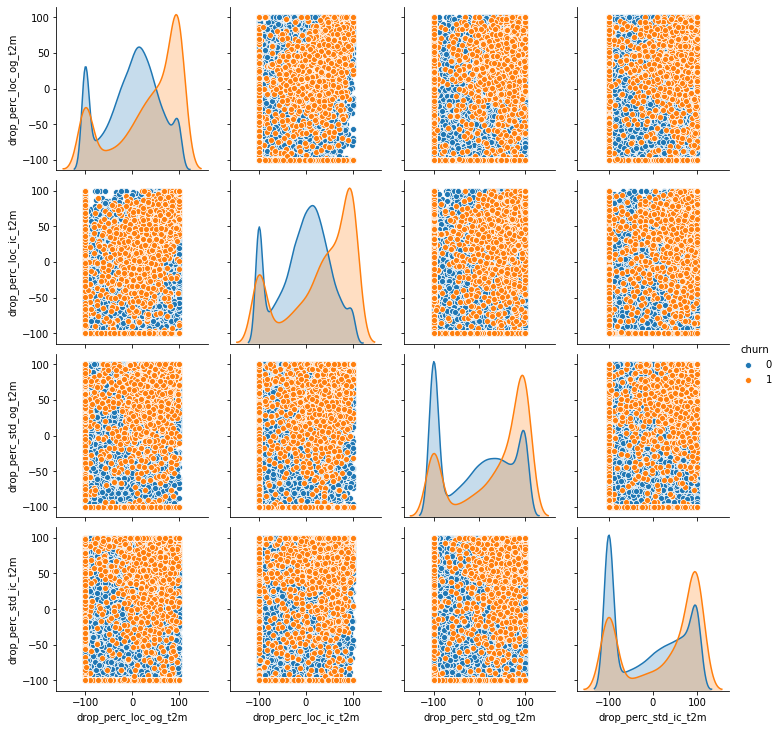

In [224]:
# Create percentage drop columns for t2m
df_clean["drop_perc_loc_og_t2m"] = drop_in_perc(df_clean.loc_og_t2m_mou_6,df_clean.loc_og_t2m_mou_7,df_clean.loc_og_t2m_mou_8)
df_clean["drop_perc_loc_ic_t2m"] = drop_in_perc(df_clean.loc_ic_t2m_mou_6,df_clean.loc_ic_t2m_mou_7,df_clean.loc_ic_t2m_mou_8)
df_clean["drop_perc_std_og_t2m"] = drop_in_perc(df_clean.std_og_t2m_mou_6,df_clean.std_og_t2m_mou_7,df_clean.std_og_t2m_mou_8)
df_clean["drop_perc_std_ic_t2m"] = drop_in_perc(df_clean.std_ic_t2m_mou_6,df_clean.std_ic_t2m_mou_7,df_clean.std_ic_t2m_mou_8)

# Since the data for individual months is highly corelated, drop the t2m columns for months 6 and 7
drop_6_7 = [x for x in t2m if x[-1] in ["6","7"]]
df_clean = df_clean.drop(drop_6_7, axis=1)

# Analysis of percentage drop columns for t2m
perc_cols2 = ["drop_perc_loc_og_t2m","drop_perc_loc_ic_t2m","drop_perc_std_og_t2m","drop_perc_std_ic_t2m"]
sns.pairplot(df_clean, x_vars=perc_cols2, y_vars=perc_cols2, hue="churn");

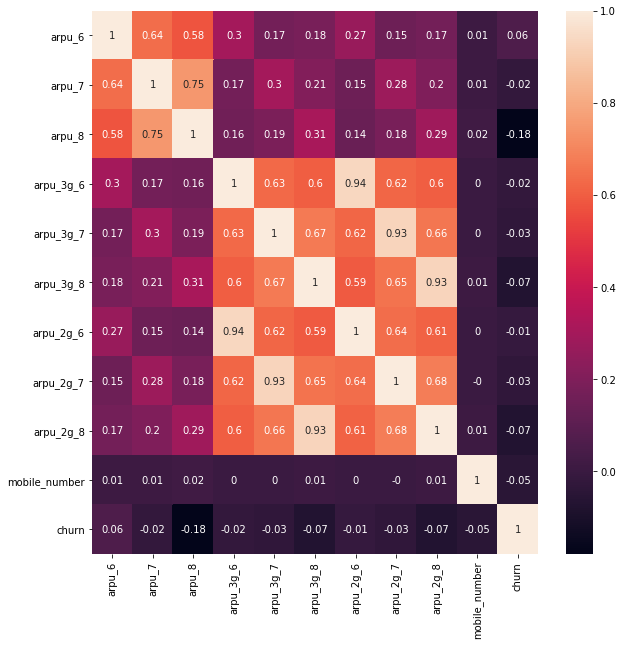

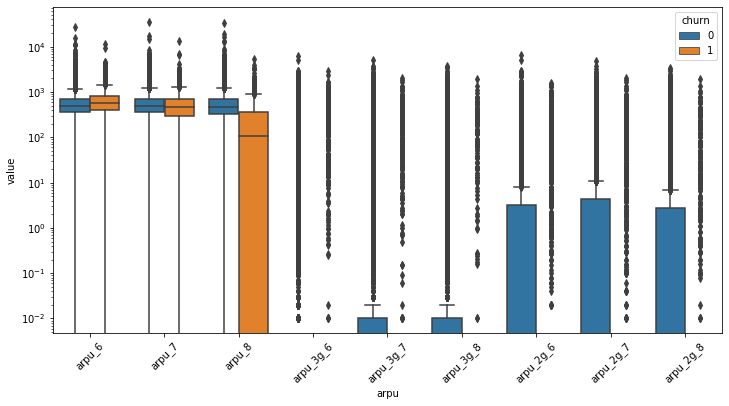

In [225]:
# Analysis of columns related to arpu (average revenue per user)
df_arpu = columns_cont(df_clean,"arpu")
arpu = df_arpu.arpu.unique()

plt.figure(figsize=(12,6))
plt.yscale('log')
sns.boxplot(x="arpu", y="value", hue="churn", data=df_arpu)
plt.xticks(rotation=45);

In [226]:
# Create combined arpu data columns
df_clean["arpu_data_6"] = df_clean["arpu_3g_6"]+df_clean["arpu_2g_6"]
df_clean["arpu_data_7"] = df_clean["arpu_3g_7"]+df_clean["arpu_2g_7"]
df_clean["arpu_data_8"] = df_clean["arpu_3g_8"]+df_clean["arpu_2g_8"]

# Create percentage drop columns for data and arpu
df_clean["drop_data_use"] = drop_in_perc(df_clean.arpu_data_6,df_clean.arpu_data_7,df_clean.arpu_data_8)
df_clean["drop_arpu"] = drop_in_perc(df_clean.arpu_6,df_clean.arpu_7,df_clean.arpu_8)

# Since the data for individual months is highly corelated, drop the arpu columns for months 6 and 7
drop_6_7 = [x for x in arpu if x[-1] in ["6","7"]]
df_clean = df_clean.drop(drop_6_7, axis=1)

In [227]:
# Create combined data volume columns
df_clean["vol_data_6"] = df_clean["vol_2g_mb_6"]+df_clean["vol_3g_mb_6"]
df_clean["vol_data_7"] = df_clean["vol_2g_mb_7"]+df_clean["vol_3g_mb_7"]
df_clean["vol_data_8"] = df_clean["vol_2g_mb_8"]+df_clean["vol_3g_mb_8"]
df_clean["tot_data_usage"] = df_clean["vol_data_6"]+df_clean["vol_data_7"]+df_clean["vol_data_8"]

# Create column for data user or not
df_clean["data_user"] = [1 if x>0 else 0 for x in df_clean["tot_data_usage"]]

# Drop the individual columns as they are highly skewed with most values as 0, and contain outliers
df_clean = df_clean.drop(["tot_data_usage","vol_data_6","vol_data_7","vol_data_8"], axis=1)

In [228]:
# Create amount per recharge columns
df_clean["amount_per_recharge_6"] = round(df_clean["total_rech_amt_6"]/df_clean["total_rech_num_6"], 2)
df_clean["amount_per_recharge_7"] = round(df_clean["total_rech_amt_7"]/df_clean["total_rech_num_7"], 2)
df_clean["amount_per_recharge_8"] = round(df_clean["total_rech_amt_8"]/df_clean["total_rech_num_8"], 2)
df_clean[['amount_per_recharge_6','amount_per_recharge_7','amount_per_recharge_8']] = df_clean[['amount_per_recharge_6','amount_per_recharge_7','amount_per_recharge_8']].fillna(0)

# Create percentage drop column for amount per recharge
df_clean["drop_amt_per_recharge"] = drop_in_perc(df_clean["amount_per_recharge_6"],df_clean["amount_per_recharge_7"],df_clean["amount_per_recharge_8"])

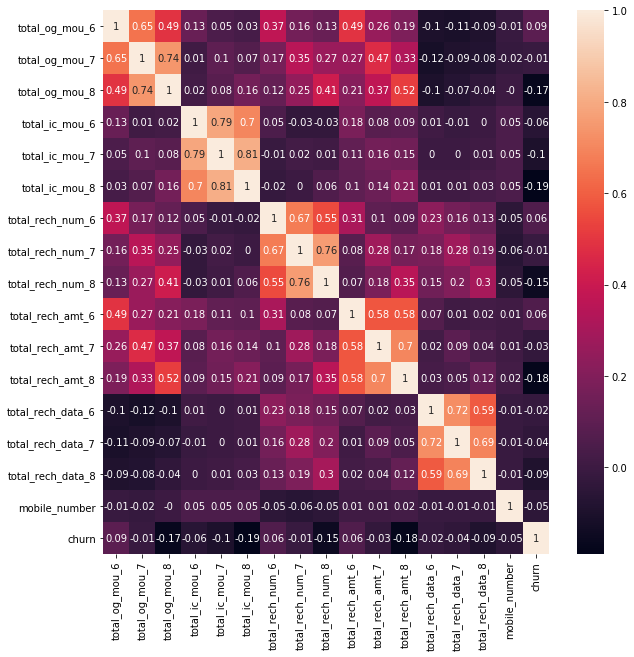

In [229]:
# Analysis of columns related to total
df_total = columns_cont(df_clean,"total")
total = df_total.total.unique()

# Since the total columns are aggregation (linear combination) of other columns, drop the total columns
df_clean = df_clean.drop(total, axis=1)

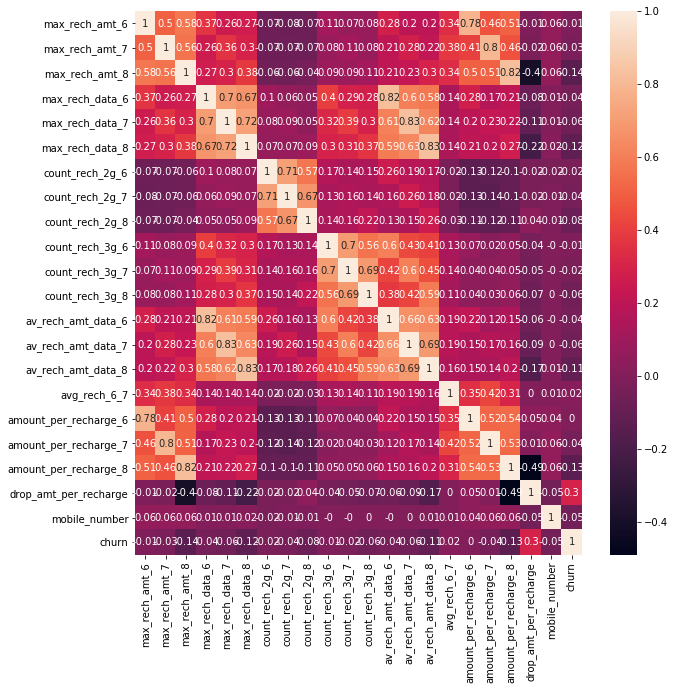

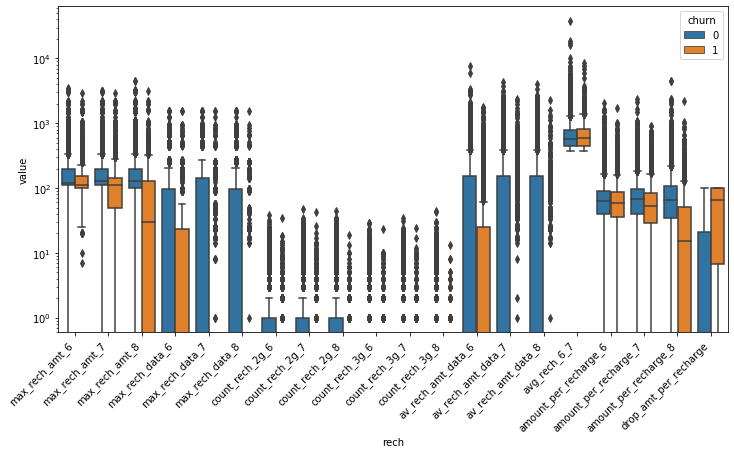

In [230]:
# Analysis of columns related to rech (recharge)
df_rech = columns_cont(df_clean,"rech")
rech = df_rech.rech.unique()

plt.figure(figsize=(12,6))
plt.yscale('log')
sns.boxplot(x="rech", y="value", hue="churn", data=df_rech)
plt.xticks(rotation=45, ha='right');

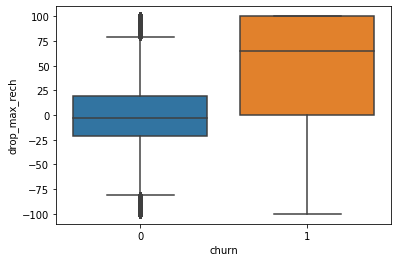

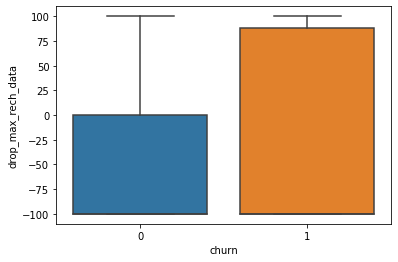

In [231]:
# Create percentage drop columns for max rech 
df_clean["drop_max_rech"] = drop_in_perc(df_clean["max_rech_amt_6"],df_clean["max_rech_amt_7"],df_clean["max_rech_amt_8"])
df_clean["drop_max_rech_data"] = drop_in_perc(df_clean["max_rech_data_6"],df_clean["max_rech_data_7"],df_clean["max_rech_data_8"])

# Drop individual columns which are highly correlated
df_clean = df_clean.drop(["max_rech_data_6","max_rech_data_7","max_rech_amt_6","max_rech_amt_7",
                          "av_rech_amt_data_6","av_rech_amt_data_7"], axis=1)

# Analysis of percentage drop columns for max rech
sns.boxplot(x="churn", y="drop_max_rech", data=df_clean)
plt.figure()
sns.boxplot(x="churn", y="drop_max_rech_data", data=df_clean);

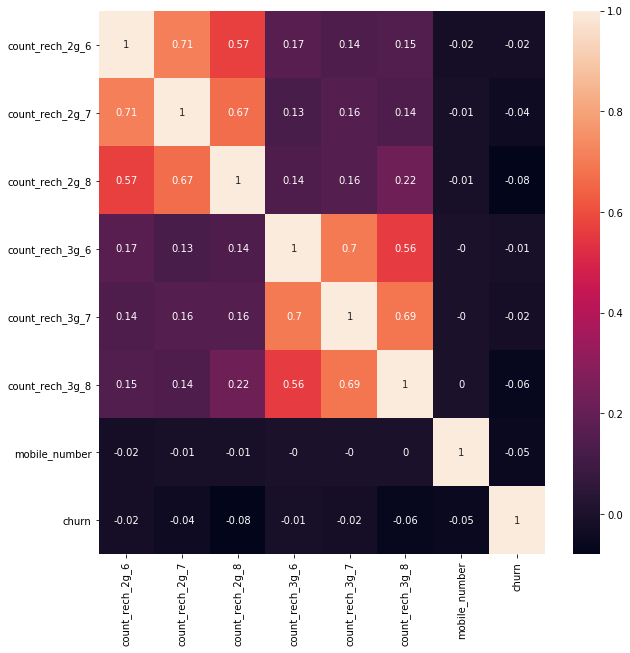

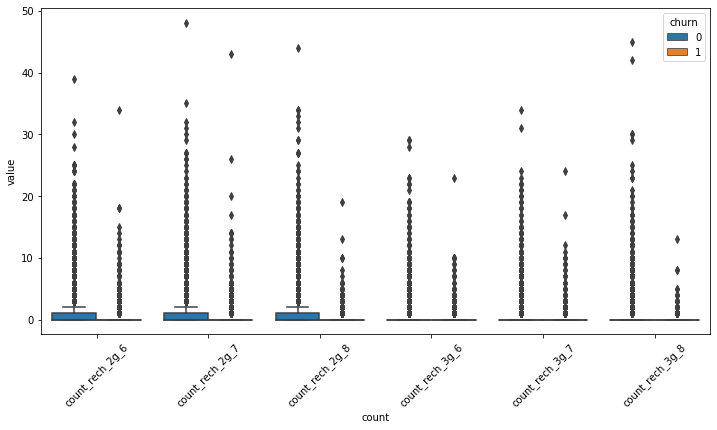

In [232]:
# Analysis of columns related to count (recharge count)
df_count = columns_cont(df_clean,"count")
count = df_count["count"].unique()

plt.figure(figsize=(12,6))
# plt.yscale('log')
sns.boxplot(x="count", y="value", hue="churn", data=df_count)
plt.xticks(rotation=45);

In [233]:
# Create combined recharge count column
df_clean["data_rech"] = (df_clean["count_rech_2g_6"]+df_clean["count_rech_2g_7"]+
                         df_clean["count_rech_2g_8"]+df_clean["count_rech_3g_6"]+
                         df_clean["count_rech_3g_7"]+df_clean["count_rech_3g_8"])

# Since the data for individual months is highly corelated, drop the count columns for months 6 and 7
drop_6_7 = [x for x in count if x[-1] in ["6","7"]]
df_clean = df_clean.drop(drop_6_7, axis=1)

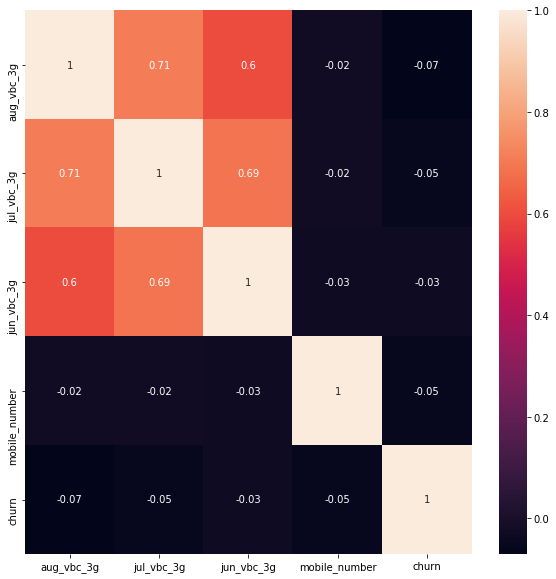

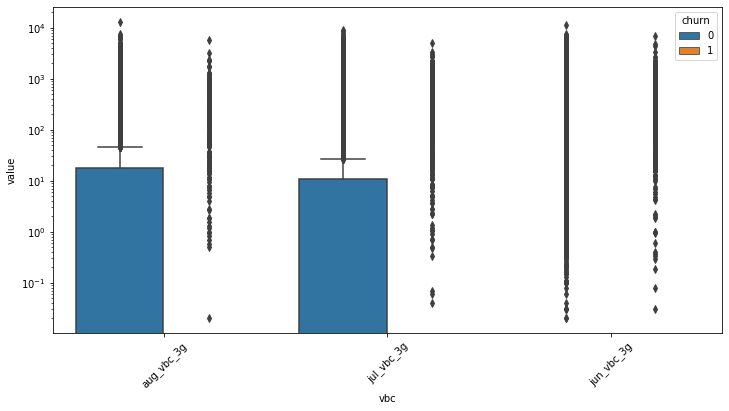

In [234]:
# Analysis of columns related to vbc (volume based cost) 
df_vbc = columns_cont(df_clean,"vbc")
vbc = df_vbc.vbc.unique()

plt.figure(figsize=(12,6))
plt.yscale('log')
sns.boxplot(x="vbc", y="value", hue="churn", data=df_vbc)
plt.xticks(rotation=45);

In [235]:
# Drop jun and jul vbc columns as they are highly corelated with aug column
df_clean = df_clean.drop(["jun_vbc_3g","jul_vbc_3g"], axis=1)

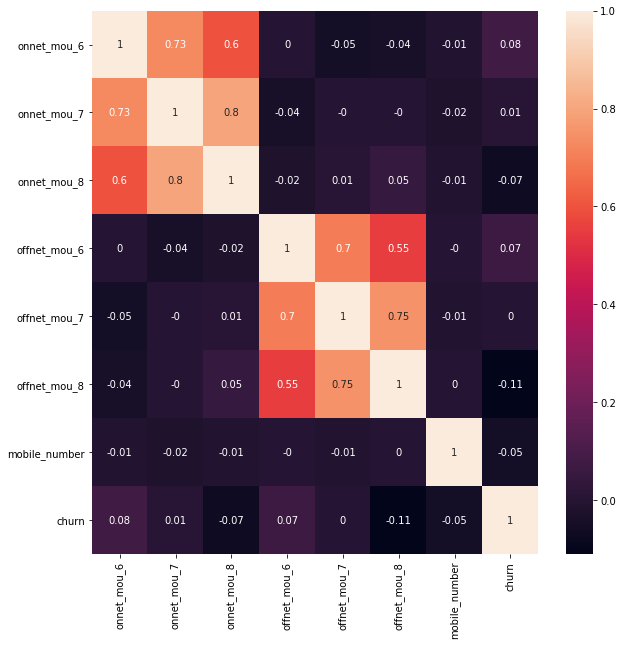

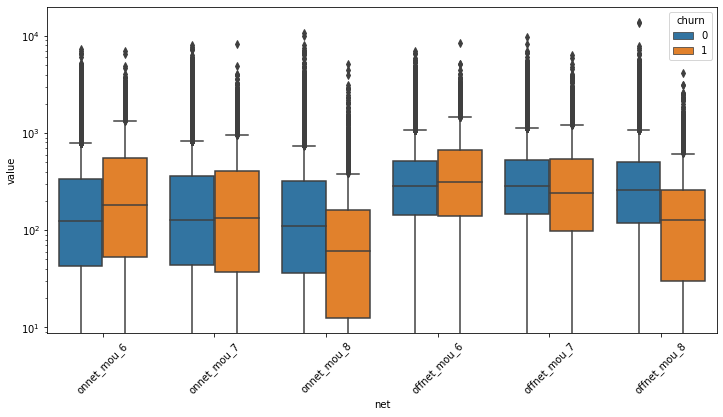

In [236]:
# Analysis of columns related to onnet/offnet (calls inside/outside the network)
df_net = columns_cont(df_clean,"net")
net = df_net.net.unique()

plt.figure(figsize=(12,6))
plt.yscale('log')
sns.boxplot(x="net", y="value", hue="churn", data=df_net)
plt.xticks(rotation=45);

In [237]:
# Create percentage drop columns for onnet/offnet
df_clean["drop_onnet"] = drop_in_perc(df_clean["onnet_mou_6"],df_clean["onnet_mou_7"],df_clean["onnet_mou_8"])
df_clean["drop_offnet"] = drop_in_perc(df_clean["offnet_mou_6"],df_clean["offnet_mou_7"],df_clean["offnet_mou_8"])

# Create offnet to total ratio columns
df_clean["offnet_onnet_6_ratio"] = round(df_clean["offnet_mou_6"]/(df_clean["offnet_mou_6"]+df_clean["onnet_mou_6"]), 2)
df_clean["offnet_onnet_7_ratio"] = round(df_clean["offnet_mou_7"]/(df_clean["offnet_mou_7"]+df_clean["onnet_mou_7"]), 2)
df_clean["offnet_onnet_8_ratio"] = round(df_clean["offnet_mou_8"]/(df_clean["offnet_mou_8"]+df_clean["onnet_mou_8"]), 2)
df_clean[['offnet_onnet_6_ratio','offnet_onnet_7_ratio','offnet_onnet_8_ratio']] = df_clean[['offnet_onnet_6_ratio','offnet_onnet_7_ratio','offnet_onnet_8_ratio']].fillna(0)

# Since the data for individual months is highly corelated, drop the net columns for months 6 and 7
drop_6_7 = [x for x in net if x[-1] in ["6","7"]]
df_clean = df_clean.drop(drop_6_7, axis=1)

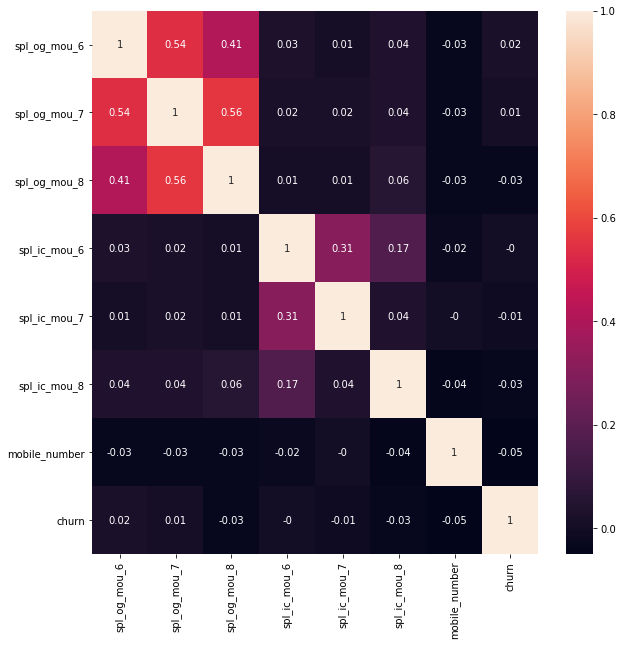

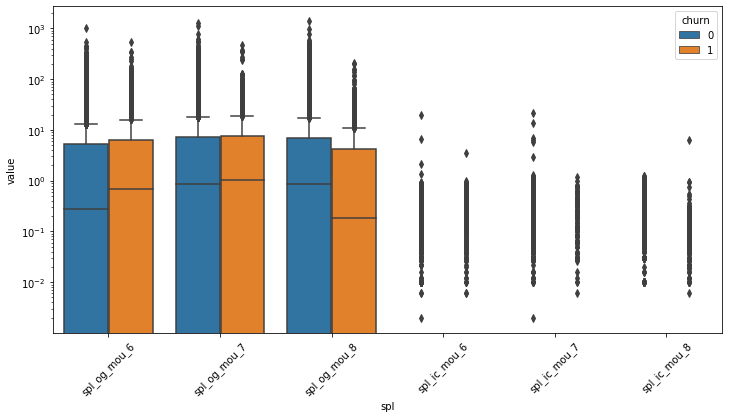

In [238]:
# Analysis of columns related to spl (special calls)
df_spl = columns_cont(df_clean,"spl")
spl = df_spl.spl.unique()

plt.figure(figsize=(12,6))
plt.yscale('log')
sns.boxplot(x="spl", y="value", hue="churn", data=df_spl)
plt.xticks(rotation=45);

In [239]:
# Create percentage drop column for spl og
df_clean["drop_spl_og"] = drop_in_perc(df_clean["spl_og_mou_6"],df_clean["spl_og_mou_7"],df_clean["spl_og_mou_8"])

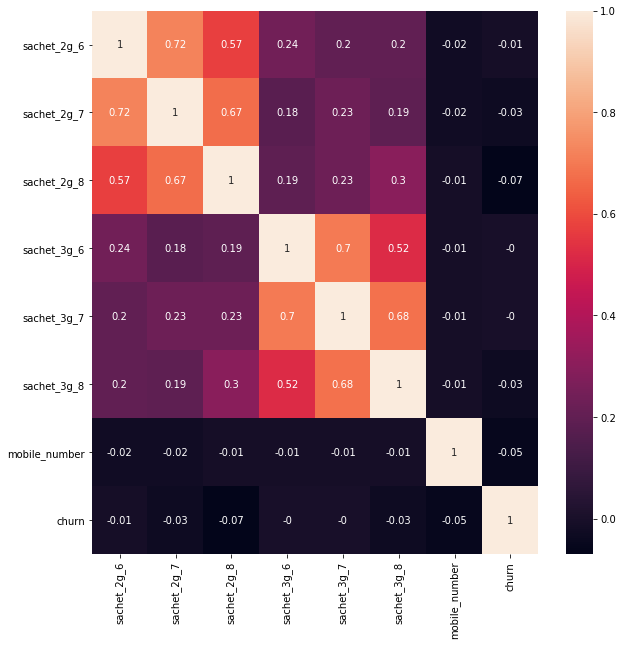

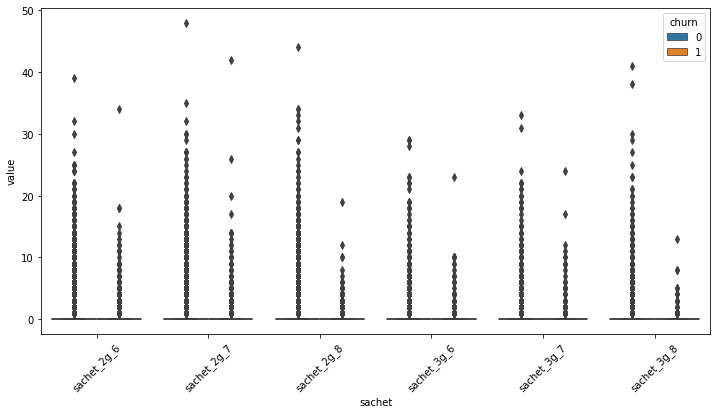

In [240]:
# Analysis of columns related to sachet
df_sachet = columns_cont(df_clean,"sachet")
sachet = df_sachet.sachet.unique()

plt.figure(figsize=(12,6))
# plt.yscale('log')
sns.boxplot(x="sachet", y="value", hue="churn", data=df_sachet)
plt.xticks(rotation=45);

In [241]:
# Since the data for individual months is highly corelated, drop the sachet columns for months 6 and 7
drop_6_7 = [x for x in sachet if x[-1] in ["6","7"]]
df_clean = df_clean.drop(drop_6_7, axis=1)

In [242]:
# Check shape of the dataframe
df_clean.shape

(29740, 125)

### Outlier treatment

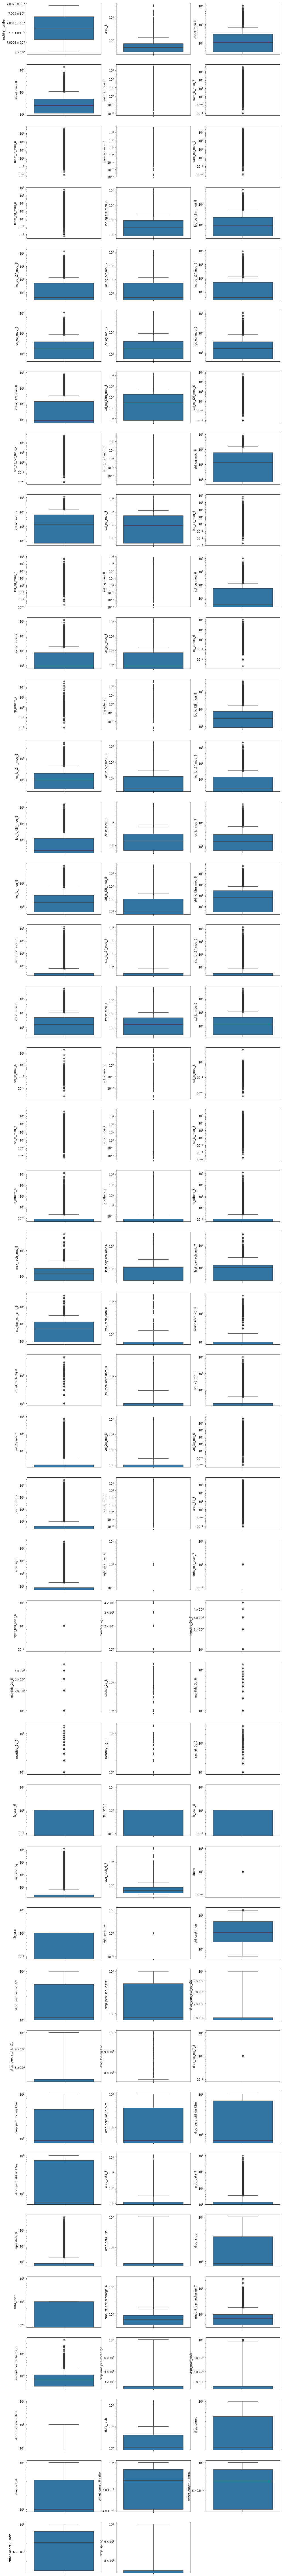

In [243]:
# Check for outliers using boxplots
cols = df_clean.columns
plt.figure(figsize=(16,len(cols)*4/3))
for i in range(len(cols)):
    plt.subplot(np.ceil(len(cols)/3), 3, i+1)
    sns.boxplot(y=df_clean[cols[i]])
    plt.yscale('log')

In [244]:
# Treat the outliers using capping
cols8 = [x for x in df_clean.columns if x[-1] in ["6","7","8"]]
for col in cols8:
    mini = df_clean[col].quantile(0.05)
    maxi = df_clean[col].quantile(0.95)
    df_clean[col] = np.clip(df_clean[col], mini, maxi)

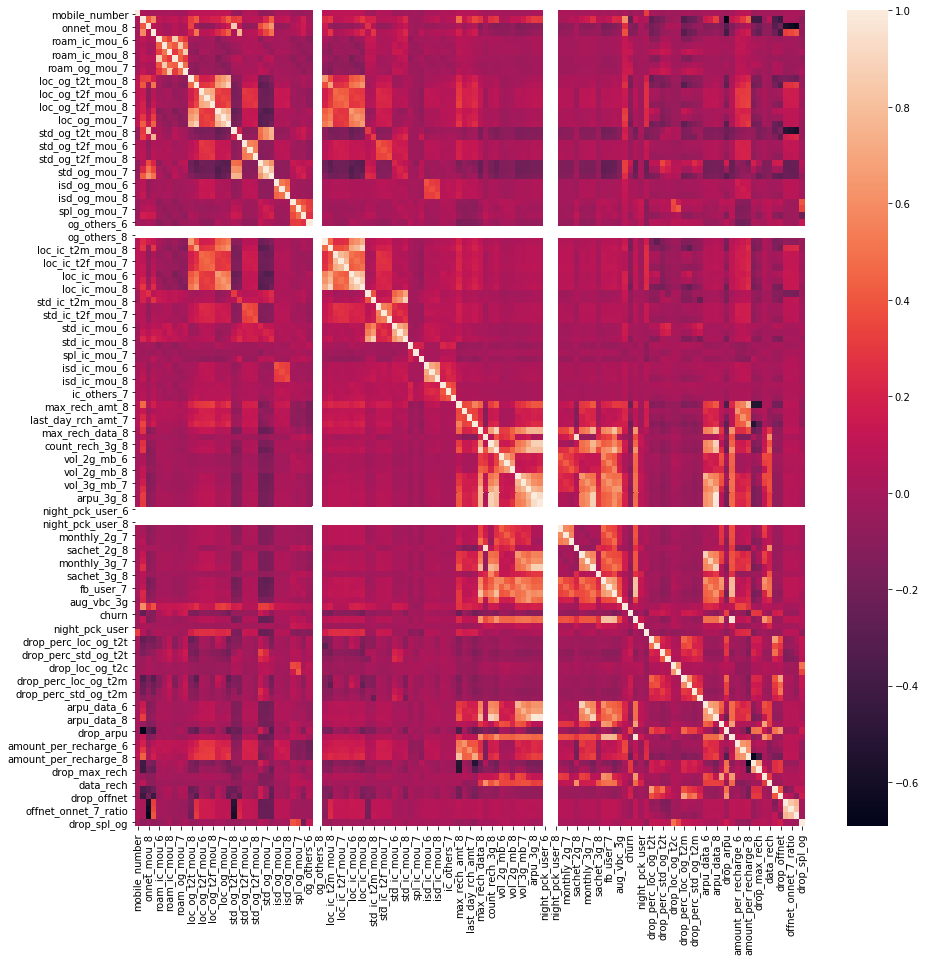

In [245]:
# Check correlation heatmap
plt.figure(figsize=(15,15))
sns.heatmap(df_clean.corr());

In [246]:
# Drop features which are highly correlated
df_clean = df_clean.drop(["night_pck_user_6","night_pck_user_7","night_pck_user_8",
                          "og_others_7","og_others_8"], axis=1)

# Check shape of the dataframe
df_clean.shape

(29740, 120)

## 5. Modelling
#### Steps include:
1. Train-test split
2. Class imbalance
3. Rescaling features
4. Model building
    * Interpretable model (no PCA)
    * Models with good prediction (with PCA)
5. Model evaluation

#### Separate customer identifier

In [247]:
# Separate mobile number column
iden = df_clean.pop('mobile_number')

### Train-test split

In [248]:
# Put feature variables to X
X = df_clean.drop('churn', axis=1)

# Put response variable to y
y = df_clean['churn']

In [249]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3,
                                                    stratify=y, random_state=42)

# Check shape of the train and test dataframes
print(X_train.shape)
print(X_test.shape)

(20818, 118)
(8922, 118)


In [250]:
# Check head of the train dataframe
X_train.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aug_vbc_3g,avg_rech_6_7,fb_user,night_pck_user,old_cust_mon,drop_perc_loc_og_t2t,drop_perc_loc_ic_t2t,drop_perc_std_og_t2t,drop_perc_std_ic_t2t,drop_loc_og_t2c,drop_loc_og_7_8,drop_perc_loc_og_t2m,drop_perc_loc_ic_t2m,drop_perc_std_og_t2m,drop_perc_std_ic_t2m,arpu_data_6,arpu_data_7,arpu_data_8,drop_data_use,drop_arpu,data_user,amount_per_recharge_6,amount_per_recharge_7,amount_per_recharge_8,drop_amt_per_recharge,drop_max_rech,drop_max_rech_data,data_rech,drop_onnet,drop_offnet,offnet_onnet_6_ratio,offnet_onnet_7_ratio,offnet_onnet_8_ratio,drop_spl_og
27122,736.270,618.71,777.59,0.0,0.0,0.0,0.0,0.0,0.0,51.49,289.7900,0.00,0.48,0.00,466.06,382.21,341.29,567.21,479.34,0.0,0.00,0.0,1383.28,1434.73,1046.56,0.2,0.00,0.0,3.55,1.08,13.89,0.0,34.61,286.630,31.86,48.26,30.38,394.64,395.84,351.63,0.00,6.91,0.00,1.71,1.06,5.98,19.46,7.98,0.4,0.0,0.25,4.530,0.0000,5.9600,0.73,0.78,2.99,150.0,50.0,20.0,144.0,25.0,1.0,0.0,25.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1057.0,0.0,0.0,27.0,30.0,32.0,-30.0,100.0,-100.0,0,17.0,6.0,51.0,-100.0,0.0,0.0,0.00,-100.0,20.0,0,71.80,47.140,78.54,-33.0,-36.0,-100.0,2.0,-21.0,41.0,0.73,0.71,0.56,-100.0
1330,382.200,184.31,188.49,0.0,0.0,0.0,0.0,0.0,0.0,20.84,181.0600,0.00,0.00,0.00,157.74,130.01,201.91,163.46,7.43,0.0,0.00,0.0,290.78,97.38,170.89,0.0,0.00,0.0,0.00,0.33,0.00,0.0,11.53,14.210,2.21,0.00,0.00,48.21,29.51,25.74,17.06,4.00,0.06,0.10,0.13,6.81,3.48,21.19,0.0,0.0,0.00,0.000,0.0000,0.0000,0.00,0.00,0.00,67.0,30.0,50.0,30.0,25.0,1.0,1.0,50.0,0.0,0.0,70.38,0.0,0.0,0.0,21.91,25.31,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,400.0,1.0,0.0,50.0,5.0,-44.0,16.0,-100.0,-100.0,1,-50.0,53.0,-100.0,-100.0,0.0,0.0,47.22,-100.0,-6.0,1,28.82,28.180,29.47,-5.0,-34.0,-100.0,2.0,15.0,-55.0,0.28,0.51,0.51,-100.0
14244,399.789,1.93,295.33,0.0,0.0,0.0,0.0,0.0,0.0,1.93,295.3300,0.00,0.00,0.00,114.33,479.96,297.26,0.00,0.00,0.0,0.00,0.0,0.00,31.14,0.00,0.0,1.08,0.0,0.00,0.00,0.00,0.0,8.48,261.680,0.00,0.00,0.00,67.74,240.83,270.16,0.00,3.05,0.00,0.00,0.00,0.00,13.78,3.05,0.0,0.0,0.00,46.411,52.0015,47.5815,0.00,4.91,0.31,25.0,120.0,10.0,25.0,25.0,1.0,1.0,50.0,0.0,0.0,14.70,0.0,0.0,0.0,21.91,178.21,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,677.5,1.0,0.0,28.0,-93.0,-100.0,100.0,-100.0,-100.0,0,0.0,-71.0,100.0,56.0,0.0,0.0,200.12,-100.0,11.0,1,60.00,185.830,12.50,90.0,91.0,-100.0,2.0,36.0,5.0,1.00,0.99,0.99,-100.0
6712,685.722,148.16,635.78,0.0,0.0,0.0,0.0,0.0,0.0,148.16,578.3600,3.38,1.10,1.71,484.58,691.44,728.24,0.00,52.28,0.0,4.69,0.0,2.60,87.28,52.28,0.0,0.00,0.0,0.00,0.61,3.41,0.0,87.93,519.592,13.46,71.29,21.01,311.79,621.33,669.08,3.78,77.44,0.00,0.60,0.00,23.09,140.53,81.23,0.0,0.0,0.00,0.000,0.0000,0.0000,0.00,0.00,0.00,144.0,110.0,150.0,144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0

### Class imbalance

In [251]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [252]:
# Check churn percentage of train data
round(100*y_train.sum()/len(y_train), 2)

50.0

### Rescaling features

We will use MinMax scaling (normalisation, min=0, max=1).

In [253]:
# Instantiate scaler object
scaler = MinMaxScaler()

# Fit and transform on the train set
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_train.columns = X.columns

# Apply scaling (only transform) on the test set
X_test = pd.DataFrame(scaler.transform(X_test))
X_test.columns = X.columns

In [254]:
# Check summary statistics for train set after MinMax scaling (min=0, max=1)
X_train.describe()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aug_vbc_3g,avg_rech_6_7,fb_user,night_pck_user,old_cust_mon,drop_perc_loc_og_t2t,drop_perc_loc_ic_t2t,drop_perc_std_og_t2t,drop_perc_std_ic_t2t,drop_loc_og_t2c,drop_loc_og_7_8,drop_perc_loc_og_t2m,drop_perc_loc_ic_t2m,drop_perc_std_og_t2m,drop_perc_std_ic_t2m,arpu_data_6,arpu_data_7,arpu_data_8,drop_data_use,drop_arpu,data_user,amount_per_recharge_6,amount_per_recharge_7,amount_per_recharge_8,drop_amt_per_recharge,drop_max_rech,drop_max_rech_data,data_rech,drop_onnet,drop_offnet,offnet_onnet_6_ratio,offnet_onnet_7_ratio,offnet_onnet_8_ratio,drop_spl_og
count,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000,38248.000000
mean,0.284602,0.167391,0.226200,0.103174,0.118927,0.140590,0.112754,0.136484,0.148584,0.143381,0.185561,0.114836,0.112813,0.106611,0.225529,0.213870,0.189299,0.124586,0.142970,0.072677,0.070670,0.068024,0.297875,0.260230,0.174377,0.072049,0.066921,0.065233,0.163634,0.172854,0.147926,0.129434,0.165016,0.194649,0.120396,0.116616,0.114693,0.237584,0.221625,0.199768,0.119603,0.138579,0.081458,0.081557,0.080531,0.192802,0.177886,0.146061,0.134267,0.055615,0.065685,0.096184,0.092735,0.082222,0.091475,0.089408,0.079551,0.250902,0.339212,0.309235,0.222349,0.126422,0.096759,0.071970,0.107810,0.090559,0.085365,0.065047,0.100757,0.099022,0.077524,0.070584,0.076664,0.081399,0.081254,0.061591,0.080608,0.104171,0.098610,0.072

### Interpretable model

### Logistic regression model

In [255]:
# Create logistic regression object
logreg = LogisticRegression(penalty='l2', random_state=42)

# Fit on train data
logreg.fit(X_train, y_train)

# Run RFE with number of output variables as 15
rfe = RFE(logreg, 15)
rfe = rfe.fit(X_train, y_train)

In [256]:
# Check results with ranking
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('arpu_8', False, 26),
 ('onnet_mou_8', False, 54),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 95),
 ('roam_ic_mou_7', False, 101),
 ('roam_ic_mou_8', False, 17),
 ('roam_og_mou_6', False, 31),
 ('roam_og_mou_7', False, 81),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_8', False, 40),
 ('loc_og_t2m_mou_8', False, 33),
 ('loc_og_t2f_mou_6', False, 75),
 ('loc_og_t2f_mou_7', False, 55),
 ('loc_og_t2f_mou_8', False, 74),
 ('loc_og_mou_6', False, 92),
 ('loc_og_mou_7', False, 7),
 ('loc_og_mou_8', False, 98),
 ('std_og_t2t_mou_8', True, 1),
 ('std_og_t2m_mou_8', False, 25),
 ('std_og_t2f_mou_6', False, 88),
 ('std_og_t2f_mou_7', False, 79),
 ('std_og_t2f_mou_8', False, 67),
 ('std_og_mou_6', False, 30),
 ('std_og_mou_7', False, 36),
 ('std_og_mou_8', True, 1),
 ('isd_og_mou_6', False, 102),
 ('isd_og_mou_7', False, 62),
 ('isd_og_mou_8', True, 1),
 ('spl_og_mou_6', False, 9),
 ('spl_og_mou_7', False, 8),
 ('spl_og_mou_8', False, 48),
 ('og_others_6', False, 44),
 ('loc_ic_t2t

In [257]:
# Include results from RFE
cols_rfe = X_train.columns[rfe.support_]
X = X_train[cols_rfe]
X.columns

Index(['offnet_mou_8', 'roam_og_mou_8', 'std_og_t2t_mou_8', 'std_og_mou_8',
       'isd_og_mou_8', 'loc_ic_mou_8', 'last_day_rch_amt_8', 'max_rech_data_8',
       'sachet_2g_8', 'fb_user', 'old_cust_mon', 'drop_loc_og_7_8',
       'arpu_data_7', 'drop_arpu', 'data_user'],
      dtype='object')

In [258]:
# Add a constant
X_train_sm = sm.add_constant(X)
# Create the first model
logr1 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
# Fit the model
logm1 = logr1.fit()
# Check summary of the model
print(logm1.summary())

# Check VIF values of the feature variables
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                38248
Model:                            GLM   Df Residuals:                    38232
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14532.
Date:                Wed, 20 May 2020   Deviance:                       29065.
Time:                        11:03:35   Pearson chi2:                 5.64e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.5787      0

,Features,VIF
9,fb_user,12.90
14,data_user,12.66
3,std_og_mou_8,10.83
0,offnet_mou_8,6.84
2,std_og_t2t_mou_8,5.75
5,loc_ic_mou_8,2.86
13,drop_arpu,2.34
10,old_cust_mon,2.33
7,max_rech_data_8,2.31
6,last_day_rch_amt_8,2.17


In [259]:
# Drop highly correlated variable, fb_user
X = X.drop('fb_user', axis=1)

# Build the next model
X_train_sm = sm.add_constant(X)
logr2 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
logm2 = logr2.fit()
# Check summary of the model
print(logm2.summary())

# Check VIF values of the feature variables
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                38248
Model:                            GLM   Df Residuals:                    38233
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14978.
Date:                Wed, 20 May 2020   Deviance:                       29955.
Time:                        11:03:37   Pearson chi2:                 4.51e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.4741      0

,Features,VIF
3,std_og_mou_8,10.83
0,offnet_mou_8,6.84
2,std_og_t2t_mou_8,5.74
5,loc_ic_mou_8,2.86
13,data_user,2.79
9,old_cust_mon,2.32
7,max_rech_data_8,2.28
12,drop_arpu,2.26
6,last_day_rch_amt_8,2.17
11,arpu_data_7,1.84


In [260]:
# Drop highly correlated variable, std_og_mou_8
X = X.drop('std_og_mou_8', axis=1)

# Build the next model
X_train_sm = sm.add_constant(X)
logr3 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
logm3 = logr3.fit()
# Check summary of the model
print(logm3.summary())

# Check VIF values of the feature variables
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                38248
Model:                            GLM   Df Residuals:                    38234
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15059.
Date:                Wed, 20 May 2020   Deviance:                       30117.
Time:                        11:03:38   Pearson chi2:                 4.43e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.4633      0

,Features,VIF
12,data_user,2.78
4,loc_ic_mou_8,2.34
8,old_cust_mon,2.31
6,max_rech_data_8,2.28
11,drop_arpu,2.25
5,last_day_rch_amt_8,2.16
0,offnet_mou_8,2.03
10,arpu_data_7,1.84
1,roam_og_mou_8,1.35
7,sachet_2g_8,1.28


We will consider this as our final model as the p-values and VIF values are within acceptable range (p-values less than 5% for significance and VIF values less than 5 for less correlation).

In [261]:
# Get the predicted probabilities on train set
y_train_prob = logm3.predict(X_train_sm)
# Get the predicted churn on train set, 1 if churn_prob > 0.5, else 0
y_train_pred = y_train_prob.map(lambda x: 1 if x>0.5 else 0)

# Find the confusion matrix on train set
print(metrics.confusion_matrix(y_train,y_train_pred))
# Find the AUC score on train set
auc_train = metrics.roc_auc_score(y_train,y_train_prob)
print(auc_train)

[[15764  3360]
 [ 3084 16040]]
0.9040595104370859


In [262]:
# Select final model features in test set
cols_logr = X.columns
X_test_1 = X_test[cols_logr]
# Add a constant
X_test_sm = sm.add_constant(X_test_1)

# Get the predicted probabilities on test set
y_test_prob = logm3.predict(X_test_sm)
# Get the predicted churn on test set, 1 if churn_prob > 0.5, else 0
y_test_pred = y_test_prob.map(lambda x: 1 if x>0.5 else 0)

# Find the confusion matrix on test set
print(metrics.confusion_matrix(y_test,y_test_pred))
# Find the AUC score on test set
auc_test = metrics.roc_auc_score(y_test,y_test_prob)
print(auc_test)

[[6768 1428]
 [ 141  585]]
0.8761954027161002


In [263]:
# Create a dataframe with model name and AUC (area under curve) scores
df_eval = pd.DataFrame({'Model':['Logistic Regression'], 'Train AUC Score':[round(auc_train,2)],
                        'Test AUC Score':[round(auc_test,2)]})

# Check the dataframe
df_eval

,Model,Train AUC Score,Test AUC Score
0,Logistic Regression,0.9,0.88


In [264]:
# ROC curve and area function
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score, linewidth=2 )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return None

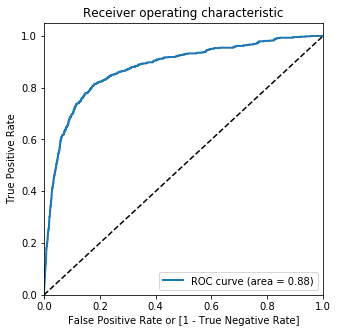

In [265]:
# Plot the ROC curve for test set
draw_roc(y_test,y_test_prob)

#### Main indicators of churn

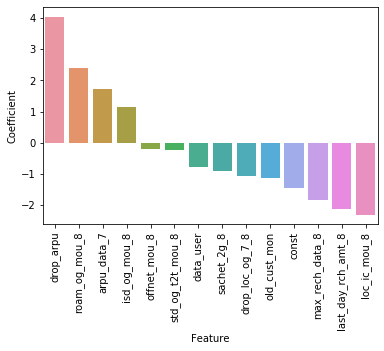

In [266]:
# Display final model features with model coefficients
parameters = pd.DataFrame(logm3.params.sort_values(ascending=False))
parameters = parameters.reset_index()
parameters.columns = ["Feature","Coefficient"]
sns.barplot(x="Feature", y="Coefficient", data=parameters)
plt.xticks(rotation=90);

### Models with good prediction

### PCA

In [267]:
# Instantiate pca object with 95% explained variance
pca = PCA(0.95, random_state=42)

# Fit and transform on the train set
X_train_pca = pca.fit_transform(X_train)

# Convert the array to a dataframe
cols_pca = ['PC{}'.format(i) for i in range(1,X_train_pca.shape[1]+1)] 
X_train_pca = pd.DataFrame(X_train_pca, columns=cols_pca)

# Check shape of the train dataframe
X_train_pca.shape

(38248, 68)

In [268]:
# Check head of the train dataframe
X_train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68
0,-0.514373,1.103695,0.209480,0.564286,0.689309,0.024176,-0.683881,0.184591,0.610184,-0.293005,-0.539855,0.294414,0.385904,-0.026516,-0.306885,0.015370,0.488852,-0.580652,0.558020,-0.070030,-0.029356,-0.671407,0.439769,0.028264,0.416125,0.269944,-0.023585,0.332759,-0.565929,0.003177,-0.208038,-0.219093,0.049735,-0.102864,-0.120945,-0.042877,0.184539,-0.106890,-0.190708,-0.201772,0.652052,-0.193938,0.123081,0.462801,-0.117384,0.231515,0.096350,-0.133394,0.016602,0.027593,-0.127812,0.228445,0.281988,-0.236150,0.017427,-0.066547,0.072077,-0.160033,-0.049281,0.120777,0.015964,0.012771,0.029807,-0.064301,0.016505,0.007397,0.078263,0.098049
1,0.399839,0.339752,-0.879752,-0.318712,0.052223,-0.892590,-0.334257,-0.246908,-0.373355,0.266479,0.095998,0.143017,-0.205513,-0.177888,-0.404462,0.729636,0.238956,-0.047084,-0.592580,0.326899,-0.262294,0.135025,0.126952,0.159605,-0.035430,-0.322507,-0.001637,-0.672096,0.087331,0.018688,-0.487689,0.169370,-0.020992,0.199171,-0.081032,0.220872,-0.208282,-0.069245,0.112041,0.208044,0.042659,0.293668,-0.388750,0.223959,0.437732,-0.447432,0.138492,0.263714,0.165879,-0.096202,0.108661,0.378784,0.101708,0.114782,-0.399033,0.118163,0.107541,-0.038166,0.096577,0.292441,0.001855,0.135444,0.156031,-0.221941,-0.157808,0.102889,-0.010300,-0.014097
2,0.604376,0.154981,0.211996,-0.286115,-0.430615,-0.517194,0.093905,-0.527377,0.787083,0.858462,0.098429,0.554530,1.547109,0.161807,0.378092,0.568333,-0.281080,0.622943,-0.409079,0.410468,-0.482916,-0.067867,0.214841,0.173931,0.118515,-0.056339,0.114373,-0.686513,0.274214,0.587685,-0.059271,-0.005364,-0.125914,0.057093,0.027208,-0.205144,-0.284197,0.038343,0.133207,0.353469,-0.162677,0.069633,-0.428487,0.560016,0.174293,-0.305299,0.336638,-0.195153,0.178818,-0.008138,0.309456,0.515982,-0.313246,0.853586,-0.147749,-0.058420,0.235881,-0.051718,0.123601,-0.515994,0.419416,0.090933,0.076599,-0.190126,-0.078960,0.305414,0.223199,-0.168955
3,0.128196,1.812526,1.100231,0.078701,0.079457,0.118241,-0.330304,-0.055510,0.180070,0.104675,-0.503944,-0.829989,0.034969,-0.569061,-0.218800,-0.033938,-0.501140,0.059548,-0.098103,0.078338,-0.193719,-0.121148,-0.226412,-0.017772,-0.220005,-0.022858,0.226424,-0.083221,0.113232,-0.088225,0.117251,-0.165719,0.108522,0.018589,-0.211231,-0.023784,-0.225542,0.242681,0.059246,0.269215,-0.020061,-0.283798,-0.014322,0.336245,0.214112,0.339212,0.278387,-0.218397,0.062976,0.304588,0.079739,-0.015453,0.033675,0.037822,-0.140555,-0.268862,-0.240444,-0.434233,-0.293211,0.102872,0.108421,-0.100646,0.080041,-0.031793,-0.015403,0.004443,-0.138112,0.123502
4,-0.291522,1.198965,0.307981,-0.579987,0.052358,-0.737299,0.081771,-0.450700,0.094332,-0.632250,-0.319599,0.061275,-0.000972,-0.594532,0.093850,-0.248300,-0.196325,0.173284,-0.373198,-0.349523,0.112767,0.841401,0.115880,0.074716,-0.032258,-0.219541,-0.283495,0.341323,0.136540,0.124767,-0.066445,0.274271,0.034785,0.066607,-0.241979,0.139468,-0.080718,-0.239150,-0.011086,-0.011590,-0.214275,-0.222861,-0.161116,0.172480,0.279059,-0.067586,0.201723,0.215895,0.280921,-0.267968,-0.186224,0.159449,0.239002,0.019864,-0.100152,-0.064245,-0.448231,-0.061603,-0.077403,-0.011022,-0.092822,0.105051,-0.063799,0.038601,-0.055357,0.156244,-0.153001,-0.061189


In [269]:
# Apply PCA (only transform) on the test set
X_test_pca = pca.transform(X_test)

# Convert the array to a dataframe
cols_pca = ['PC{}'.format(i) for i in range(1,X_test_pca.shape[1]+1)] 
X_test_pca = pd.DataFrame(X_test_pca, columns=cols_pca)
# Check shape of the test dataframe
X_test_pca.shape

(8922, 68)

### Regularised Logistic Regression

In [270]:
# Create logistic regression object
log_pca = LogisticRegression(random_state=42)

In [271]:
# List of alphas to tune
params = {'C':[0.0001,0.001,0.01,0.1,1]}

# Grid-search cross-validation
folds = 5
model_cv = GridSearchCV(estimator = log_pca, 
                        param_grid = params, 
                        scoring = 'roc_auc', 
                        cv = folds, 
                        return_train_score = True,
                        verbose = 1,
                        n_jobs = -1)

# Fit on train data
model_cv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)

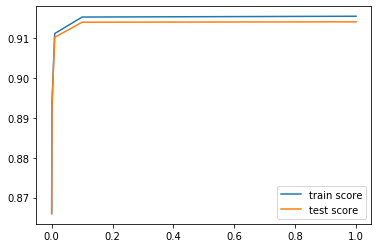

In [272]:
# Obtain results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results['param_C'] = cv_results['param_C'].astype('float32')

# Plot mean train and test scores
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.legend(['train score', 'test score'], loc='best');

In [273]:
# Instantiate logistic regression object with C=0.1
log_pca = LogisticRegression(C=0.1, random_state=42)

# Fit on train data
log_pca.fit(X_train_pca, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [274]:
# Get the predictions on train set
y_train_prob = log_pca.predict_proba(X_train_pca)[:,1]
y_train_pred = log_pca.predict(X_train_pca)

# Find the confusion matrix and AUC score on train set
print(metrics.confusion_matrix(y_train,y_train_pred))
auc_train = metrics.roc_auc_score(y_train,y_train_prob)
print(auc_train)

[[15979  3145]
 [ 2825 16299]]
0.9151148504671961


In [275]:
# Get the predictions on test set
y_test_prob = log_pca.predict_proba(X_test_pca)[:,1]
y_test_pred = log_pca.predict(X_test_pca)

# Find the confusion matrix and AUC score on test set
print(metrics.confusion_matrix(y_test,y_test_pred))
auc_test = metrics.roc_auc_score(y_test,y_test_prob)
print(auc_test)

[[6860 1336]
 [ 159  567]]
0.8735101581501156


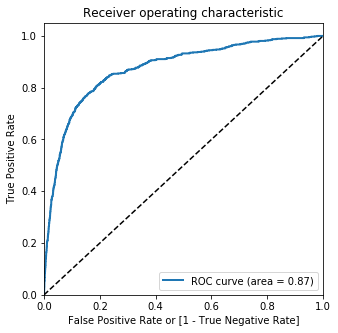

In [276]:
# Plot the ROC curve for test set
draw_roc(y_test,y_test_prob)

In [277]:
# Update the evaluation dataframe with model name and AUC (area under curve) scores
df_eval_1 = pd.DataFrame({'Model':['Logistic Regression with PCA'], 'Train AUC Score':[round(auc_train,2)],
                          'Test AUC Score':[round(auc_test,2)]})
df_eval = df_eval.append(df_eval_1)

# Check the dataframe
df_eval

,Model,Train AUC Score,Test AUC Score
0,Logistic Regression,0.90,0.88
0,Logistic Regression with PCA,0.92,0.87


### Decision Tree with PCA

In [278]:
# Create decision tree object
dt = DecisionTreeClassifier(max_depth=8, criterion="entropy", min_samples_split=600,
                            random_state=42)

# Fit on train data
dt.fit(X_train_pca, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=600,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [279]:
# Get the predictions on train set
y_train_prob = dt.predict_proba(X_train_pca)[:,1]
y_train_pred = dt.predict(X_train_pca)

# Find the confusion matrix and AUC score on train set
print(metrics.confusion_matrix(y_train,y_train_pred))
auc_train = metrics.roc_auc_score(y_train,y_train_prob)
print(auc_train)

[[15601  3523]
 [ 3650 15474]]
0.8914698759110665


In [280]:
# Get the predictions on test set
y_test_prob = dt.predict_proba(X_test_pca)[:,1]
y_test_pred = dt.predict(X_test_pca)

# Find the confusion matrix and AUC score on test set
print(metrics.confusion_matrix(y_test,y_test_pred))
auc_test = metrics.roc_auc_score(y_test,y_test_prob)
print(auc_test)

[[6633 1563]
 [ 217  509]]
0.8188683386507157


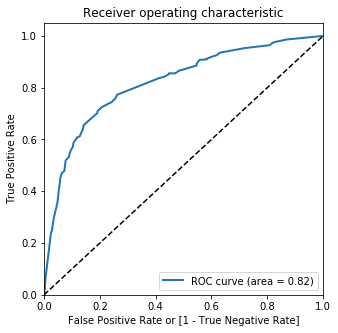

In [281]:
# Plot the ROC curve for test set
draw_roc(y_test,y_test_prob)

In [282]:
# Update the evaluation dataframe with model name and AUC (area under curve) scores
df_eval_1 = pd.DataFrame({'Model':['Decision Tree with PCA'], 'Train AUC Score':[round(auc_train,2)],
                          'Test AUC Score':[round(auc_test,2)]})
df_eval = df_eval.append(df_eval_1)

# Check the dataframe
df_eval

,Model,Train AUC Score,Test AUC Score
0,Logistic Regression,0.90,0.88
0,Logistic Regression with PCA,0.92,0.87
0,Decision Tree with PCA,0.89,0.82


### Decision Tree without PCA

In [283]:
# Create decision tree object
dt = DecisionTreeClassifier(max_depth=8, criterion="entropy", min_samples_split=800,min_samples_leaf=300,
                            random_state=42)

# Fit on train data
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=300, min_samples_split=800,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [284]:
# Get the predictions on train set
y_train_prob = dt.predict_proba(X_train)[:,1]
y_train_pred = dt.predict(X_train)

# Find the confusion matrix and AUC score on train set
print(metrics.confusion_matrix(y_train,y_train_pred))
auc_train = metrics.roc_auc_score(y_train,y_train_prob)
print(auc_train)

[[16952  2172]
 [ 1989 17135]]
0.9577799284021877


In [285]:
# Get the predictions on test set
y_test_prob = dt.predict_proba(X_test)[:,1]
y_test_pred = dt.predict(X_test)

# Find the confusion matrix and AUC score on test set
print(metrics.confusion_matrix(y_test,y_test_pred))
auc_test = metrics.roc_auc_score(y_test,y_test_prob)
print(auc_test)

[[7285  911]
 [ 170  556]]
0.891585057281184


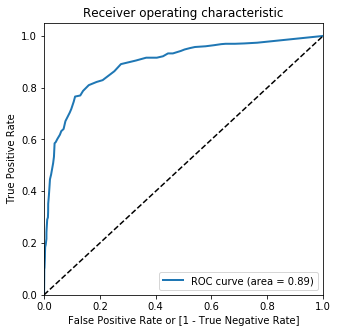

In [286]:
# Plot the ROC curve for test set
draw_roc(y_test,y_test_prob)

In [287]:
# Update the evaluation dataframe with model name and AUC (area under curve) scores
df_eval_1 = pd.DataFrame({'Model':['Decision Tree without PCA'], 'Train AUC Score':[round(auc_train,2)],
                          'Test AUC Score':[round(auc_test,2)]})
df_eval = df_eval.append(df_eval_1)

# Check the dataframe
df_eval

,Model,Train AUC Score,Test AUC Score
0,Logistic Regression,0.90,0.88
0,Logistic Regression with PCA,0.92,0.87
0,Decision Tree with PCA,0.89,0.82
0,Decision Tree without PCA,0.96,0.89


### Random Forest with PCA

In [288]:
# Create random forest object
rf = RandomForestClassifier(n_estimators=250, criterion="entropy", min_samples_split=800,
                            n_jobs=-1)

# Fit on train data
rf = rf.fit(X_train_pca, y_train)

In [289]:
# Get the predictions on train set
y_train_prob = rf.predict_proba(X_train_pca)[:,1]
y_train_pred = rf.predict(X_train_pca)

# Find the confusion matrix and AUC score on train set
print(metrics.confusion_matrix(y_train,y_train_pred))
auc_train = metrics.roc_auc_score(y_train,y_train_prob)
print(auc_train)

[[17151  1973]
 [ 3393 15731]]
0.9364329811613556


In [290]:
# Get the predictions on test set
y_test_prob = rf.predict_proba(X_test_pca)[:,1]
y_test_pred = rf.predict(X_test_pca)

# Find the confusion matrix and AUC score on test set
print(metrics.confusion_matrix(y_test,y_test_pred))
auc_test = metrics.roc_auc_score(y_test,y_test_prob)
print(auc_test)

[[7256  940]
 [ 259  467]]
0.8562728644087622


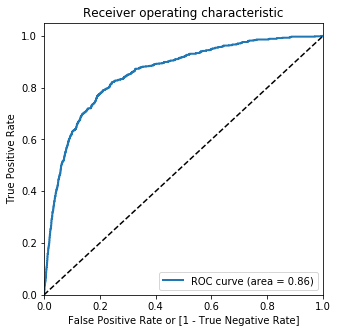

In [291]:
# Plot the ROC curve for test set
draw_roc(y_test,y_test_prob)

In [292]:
# Update the evaluation dataframe with model name and AUC (area under curve) scores
df_eval_1 = pd.DataFrame({'Model':['Random Forest'], 'Train AUC Score':[round(auc_train,2)],
                          'Test AUC Score':[round(auc_test,2)]})
df_eval = df_eval.append(df_eval_1)

# Check the dataframe
df_eval

,Model,Train AUC Score,Test AUC Score
0,Logistic Regression,0.90,0.88
0,Logistic Regression with PCA,0.92,0.87
0,Decision Tree with PCA,0.89,0.82
0,Decision Tree without PCA,0.96,0.89
0,Random Forest,0.94,0.86


### Random Forest without PCA

In [293]:
# Create random forest object
rf_1 = RandomForestClassifier(n_estimators=250, criterion="entropy", min_samples_split=600)

# Fit on train data
rf_1 = rf_1.fit(X_train, y_train)

In [294]:
# Get the predictions on train set
y_train_prob = rf_1.predict_proba(X_train)[:,1]
y_train_pred = rf_1.predict(X_train)

# Find the confusion matrix and AUC score on train set
print(metrics.confusion_matrix(y_train,y_train_pred))
auc_train = metrics.roc_auc_score(y_train,y_train_prob)
print(auc_train)

[[17406  1718]
 [ 1854 17270]]
0.9725792826621761


In [295]:
# Get the predictions on test set
y_test_prob = rf_1.predict_proba(X_test)[:,1]
y_test_pred = rf_1.predict(X_test)

# Find the confusion matrix and AUC score on test set
print(metrics.confusion_matrix(y_test,y_test_pred))
auc_test = metrics.roc_auc_score(y_test,y_test_prob)
print(auc_test)

[[7494  702]
 [ 181  545]]
0.9211370325106516


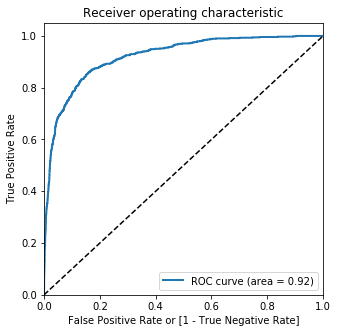

In [296]:
# Plot the ROC curve for test set
draw_roc(y_test,y_test_prob)

In [297]:
# Update the evaluation dataframe with model name and AUC (area under curve) scores
df_eval_1 = pd.DataFrame({'Model':['Random Forest without PCA'], 'Train AUC Score':[round(auc_train,2)],
                          'Test AUC Score':[round(auc_test,2)]})
df_eval = df_eval.append(df_eval_1)

# Check the dataframe
df_eval

,Model,Train AUC Score,Test AUC Score
0,Logistic Regression,0.90,0.88
0,Logistic Regression with PCA,0.92,0.87
0,Decision Tree with PCA,0.89,0.82
0,Decision Tree without PCA,0.96,0.89
0,Random Forest,0.94,0.86
0,Random Forest without PCA,0.97,0.92


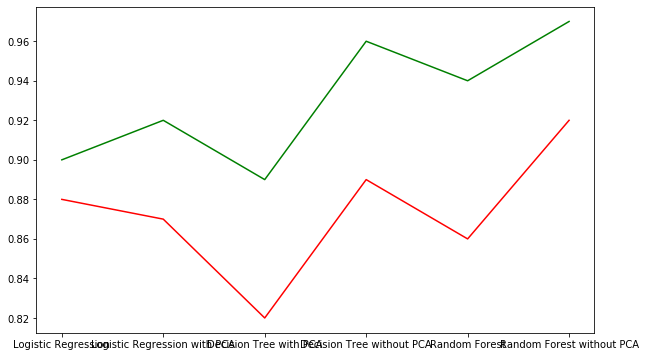

In [298]:
# Plot model performance
plt.figure(figsize=(10,6))
plt.plot("Model", "Train AUC Score", data=df_eval, color='g')
plt.plot("Model", "Test AUC Score", data=df_eval, color='r');

Modelling was done with and without PCA to find main indicators for churn. PCA was performed next to reduce dimensionality and multicollinearity. Grid-search cross-validation was performed for hyperparameter tuning. Then multiple models were built for good prediction.

Random Forest without PCA proved to be a reliable model amongst others.

### Top Features

In [308]:
importances = rf_1.feature_importances_
col_names =  X.columns

RF_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True),columns={'Value','Feature'})
RF_feature_importance.head(10)

,Value,Feature
0,0.155811,old_cust_mon
1,0.144756,last_day_rch_amt_8
2,0.049716,offnet_mou_8
3,0.019288,sachet_2g_8
4,0.013193,arpu_data_7
5,0.011129,loc_ic_mou_8
6,0.006626,drop_loc_og_7_8
7,0.004170,std_og_t2t_mou_8
8,0.001996,max_rech_data_8
9,0.001675,isd_og_mou_8


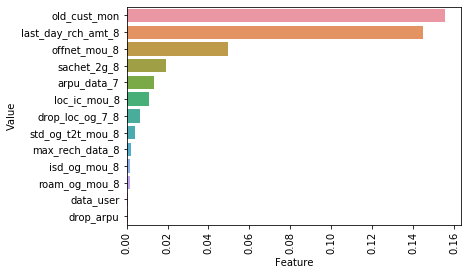

In [309]:
# Display final model features with model coefficients
parameters = RF_feature_importance.sort_values(by ="Value",ascending=False)
# parameters = parameters.reset_index()
parameters.columns = ["Feature","Value"]
sns.barplot(x="Feature", y="Value", data=parameters)
plt.xticks(rotation=90);

# Recommendations to Business 

#### To drived churn the following parameters can be considered.

- The recharge amount during the action pahse compared to good month (6th and 7th month) has reduced
- The average revinue from the data usage for month prior to action month.
- The amount of calls to other networks
- Local incoming calls for the customer
- Drop in local out going call compared to good months